In the single progenitor model from Clayton et al, there are two types of basal cells: progenitor cells and differentiated cells.  
The differentiated cells no longer divide, and are just temporarily in the basal layer until they stratify into the suprabasal layers.   
The total clone size distribution (including both progenitor and differentiated cells) can be approximated by scaling the clone sizes using progenitor cells only.   

Most of the simulations run by this software can be thought of as either 
- ignoring the differentiated cells (and the full clone sizes can be obtained by scaling)
- or can be considered as a simulation of the whole of the basal layer, but with less control over the relative rates of division and stratification.   

There is also an option in the Branching, Moran and Moran2D simulations to explicitly simulate the number of differentiated cells. It is important to note though that the differentiated cells do not in any way affect the behaviour of the progenitor cells. They have no physical position on the 2D grids for example.   


There are two new parameters to define to simulate the differentiated cells: r and gamma.  

r is the proportion of cell divisions that are symmetrical, i.e. that produce either two progenitor cells or two differentiated cells. The simulations of differentiated cells essentially 
- track the differentiated cells produced by the symmetric differentiation divisions
- additionally simulate the asymmetric divisions (that produce one progenitor and one differentiated cell).

gamma is the stratification rate of the differentiated cells.  

All simulations start with proliferative cells only. 

These simulations are not often used and not all features/plots are adapted to include the differentiated cells.   
If in doubt, you can calculate the results you need from the sim.population_array (which contains the proliferative cell counts) and the sim.diff_cell_population array (which contains the differentatiated cell counts). 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from clone_competition_simulation import Parameters

In [3]:
# To explicitly simulate the differentiated cells, define the r and gamma parameters
p = Parameters(algorithm='Moran', initial_size_array=np.ones(5000), print_warnings=False, 
              r=0.15, gamma=3)
s = p.get_simulator()
s.run_sim()

In [4]:
# The clone sizes are stored in two arrays, one for the progenitor cells (same as before), 
# and one for the differentiated cells

# These two sparse matrices hold the cell numbers. 
# They have the same dimensions, and can be added to get the total basal clone sizes. 
s.population_array, s.diff_cell_population 

(<5000x101 sparse matrix of type '<class 'numpy.float64'>'
 	with 121665 stored elements in List of Lists format>,
 <5000x101 sparse matrix of type '<class 'numpy.float64'>'
 	with 134830 stored elements in List of Lists format>)

In [5]:
# For example, to get the clone sizes for clone_id=4 over time, use row 4 of the arrays
a_cells = s.population_array[4].toarray().astype(int)[0]
b_cells = s.diff_cell_population[4].toarray().astype(int)[0]
total_cells = a_cells + b_cells

# Show the clone size (proliferative only, differentiated only, and total) at the first few sample times
print('Proliferative cells :', a_cells[:8])
print('Differentiated cells:', b_cells[:8])
print('Total cells         :', total_cells[:8])

Proliferative cells : [1 1 1 1 1 1 1 1]
Differentiated cells: [0 0 2 2 2 2 2 2]
Total cells         : [1 1 3 3 3 3 3 3]


In [6]:
# You can get the non-mutant clone size distributions (lineage tracing-style) for the clones with and without the 
# differentiated cells using the include_diff_cells option.  
(s.get_clone_size_distribution_for_non_mutation(include_diff_cells=False, t=2),
s.get_clone_size_distribution_for_non_mutation(include_diff_cells=True, t=2))

(array([3343,  537,  346,  264,  172,  124,   76,   56,   32,   21,    9,
           2,    1,    6,    3,    2,    3,    1,    0,    1,    1]),
 array([2750,  363,  259,  191,  202,  184,  127,  113,  109,  104,   93,
          60,   65,   39,   46,   43,   47,   26,   28,   20,   25,   11,
          13,   11,   11,    6,    6,    6,    6,    3,    5,    3,    3,
           3,    4,    0,    3,    1,    0,    0,    2,    0,    3,    1,
           0,    1,    0,    1,    0,    2,    0,    1]))

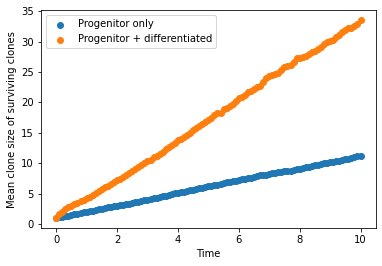

In [7]:
# There is also an `include_diff_cells` option in some of the plotting functions
s.plot_mean_clone_size_graph_for_non_mutation(include_diff_cells=False, show_spm_fit=False, 
                                              legend_label='Progenitor only')
s.plot_mean_clone_size_graph_for_non_mutation(include_diff_cells=True, show_spm_fit=False, ax=plt.gca(), 
                                             legend_label='Progenitor + differentiated')
plt.legend();

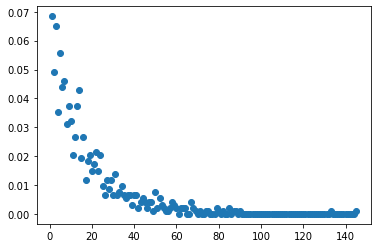

In [8]:
s.plot_clone_size_distribution_for_non_mutation(include_diff_cells=True, t=5)

In [9]:
# And the same goes for simulations with ongoing mutations
p = Parameters(algorithm='Moran', initial_cells=5000, print_warnings=False, 
               mutation_rates=0.01, r=0.15, gamma=3)
s = p.get_simulator()
s.run_sim()

# Get the mutant clone sizes
print(s.get_mutant_clone_sizes(include_diff_cells=True, t=3, non_zero_only=True))
# Or the distribution of clone sizes (np.bincount)
s.get_mutant_clone_size_distribution(include_diff_cells=True, t=3)

[ 3  8  1  5  1  3 13  1  9 19  1  1  6  4 13  1  5  2  2 11  2  7  4  2
  4 17  2  3  9  8  8  1  2  4  1  8  2 14  1  2  6  3  1 11  9  5  5  9
  1  2  1  2  8 11  4  3  4  1  4  5  3  1  2  4  2  2  2  4  1  1  5  1
  3  3  1  2  1  2  1  1  1  2  1]


array([411,  23,  17,   8,   9,   6,   2,   1,   5,   4,   0,   3,   0,
         2,   1,   0,   0,   1,   0,   1])

# Speeding up simulations

The creation and death/stratification of many differentiated cells have to simulated.  
For simulations with long gaps between sampling points, many of the differentiated cells may be born and die without being 'observed' at a sampling point. Since the differentiated cells also have no affect on any other cells, this means the 'unobserved' differentiated cells use computational resources but have no impact on the results at all.   

It is possible to skip the simulation of the differentiated cells that are born a long time before the next sampling point and are very likely to die without being recorded. In some cases, this can substantially reduce the simulation time.  
The stratification times are drawn from an exponential distribution, meaning there is no upper limit and we cannot guarantee that a cell won't survive until the next sampling point unless we simulate it (draw that random stratification time). Instead, it is set at a probability, so that cells with, say, a greater than 99.9% chance of dying before the next sampling point will not be simulated. This may lead to a very slight underestimate of the clone sizes.   


In [10]:
%%time
# Time a simulation with no differentiated cells simulated. 
# Only record clone sizes at a couple of widely spaced time points. 
p = Parameters(algorithm='Moran2D', initial_grid=np.arange(10000).reshape(100, 100), 
               times=[0, 20, 40], print_warnings=False
              )
s = p.get_simulator()
s.run_sim()

CPU times: user 12.9 s, sys: 116 ms, total: 13 s
Wall time: 13 s


In [11]:
%%time
# Simulate with differentiated cells. 
# It takes much longer because of all of the extra differentiated cells that need to be simulated. 
np.random.seed(0)
p = Parameters(algorithm='Moran2D', initial_grid=np.arange(10000).reshape(100, 100), 
               times=[0, 20, 40], print_warnings=False,
               r=0.15, gamma=6,
              )
s = p.get_simulator()
s.run_sim()

CPU times: user 40.4 s, sys: 391 ms, total: 40.8 s
Wall time: 41 s


In [12]:
%%time
# Only simulating differentiated cells with a 99.9% chance of being 'observed' 
# substantially speeds up the simulation
np.random.seed(0)
p = Parameters(algorithm='Moran2D', initial_grid=np.arange(10000).reshape(100, 100), 
               times=[0, 20, 40], print_warnings=False,
               r=0.15, gamma=6, 
               stratification_sim_percentile=0.999
              )
s2 = p.get_simulator()
s2.run_sim()

CPU times: user 14.6 s, sys: 102 ms, total: 14.7 s
Wall time: 14.8 s


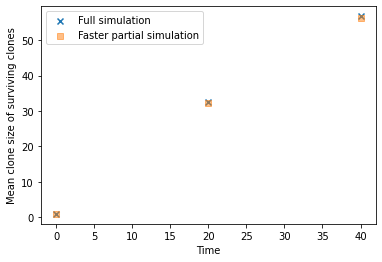

In [13]:
# The partial simulation of differentiated cells is far faster, and still quite similar to the full simulation
# (stochasticity also causes some differences here)
s.plot_mean_clone_size_graph_for_non_mutation(include_diff_cells=True, show_spm_fit=False, 
                                              legend_label='Full simulation', 
                                              plot_kwargs={'marker': 'x'})
s2.plot_mean_clone_size_graph_for_non_mutation(include_diff_cells=True, ax=plt.gca(), show_spm_fit=False, 
                                              legend_label='Faster partial simulation', 
                                              plot_kwargs={'marker': 's', 'alpha': 0.5})
plt.legend();